# SECOP 2 - XGBosst classifier


In [1]:
#!pip install plotly --upgrade

In [2]:
import pandas as pd
import numpy as np
import datetime
from plotly.offline import init_notebook_mode, iplot
import plotly.graph_objs as go
from plotly.tools import FigureFactory as FF
from warnings import filterwarnings
pd.options.display.max_columns = 500

In [3]:
#pip install plotly_express

In [4]:
import seaborn as sns
import plotly_express as px
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

In [5]:
import psycopg2
engine = psycopg2.connect(
    database="final_db",
    user="juan",
    password="1234",
    host="nps-demo-instance.c2fezqs1nmx5.us-east-2.rds.amazonaws.com",
    port='5432'
)

ModuleNotFoundError: No module named 'psycopg2'

In [ ]:
cursor=engine.cursor()

In [ ]:
import pandas as pd

sql = """
SELECT *
FROM fix_secopi
limit 10000
"""
df=pd.read_sql(sql, con=engine)

In [ ]:

df.info()

## Objetivo

El objetivo del notebook es desarrollar modelos con la información actualmente disponible en la bases de datos fix_secopi. 
Esta base de datos contiene las siguientes modificaciones respecto a la base de datos del secop:

    1- Se incluyo la columna "SANCIÓN", la cual incluye un identificación para los contratos que han sido reportados como contratos con eventos de corrupción.
    
    2- Se incluyo la columna "Terminado" indica que un contrato ha sido entregado o finalizado de forma adecuada. Los contratos que presentan sanción no puede ser calificado como terminado
    
    
- El trabajo a desarrollar considera la selección de columnas de interés 
- Desarrollo de cluster con los datos con el objetivo de buscar alguna estructura en la data
- desarrollo de modelo de logistic regression a fin de plantear un posible modelo de predicción o score de corrupción [y = sanción y X= variables de interés]
- Desarrollo de RF a fn de encontrar un modelo de clasificación sobre la variable sanción

### EDA básico

In [0]:
df_sample=df.copy()

In [59]:
df_sample.describe().T

,count,mean,std,min,25%,50%,75%,max
cuantia_contrato,10000.0,8.388859e+07,3.236906e+09,0.000000,2.080000e+06,4.000000e+06,9.600000e+06,3.120000e+11
valor_contrato_con_adiciones,10000.0,8.438087e+07,3.237136e+09,0.000000,2.080150e+06,4.000000e+06,9.600000e+06,3.120000e+11
valor_total_de_adiciones,10000.0,4.922771e+05,1.290433e+07,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,7.663218e+08
latitud,9805.0,7.913708e+00,9.541207e+00,-4.215280,3.437220e+00,5.535280e+00,9.304720e+00,4.813330e+01
longitud,9805.0,-7.482569e+01,1.707156e+00,-77.281113,-7.568111e+01,-7.528189e+01,-7.400481e+01,-6.748588e+01


### EDA Histogramas por columnas de interés como contratos de mayor cuantía o datos de mayor cantidad de contratos terminados

In [60]:
df.columns.unique()

Index(['identificacion_del_contratista', 'nombre_de_la_entidad',
       'nit_de_la_entidad', 'nivel_entidad', 'orden_entidad',
       'municipio_obtencion', 'municipio_entrega', 'numero_del_contrato',
       'numero_de_proceso', 'nom_raz_social_contratista', 'moneda',
       'cuantia_contrato', 'valor_contrato_con_adiciones',
       'valor_total_de_adiciones', 'sancion', 'anno_firma_del_contrato',
       'estado_del_proceso', 'fecha_de_firma_del_contrato',
       'fecha_ini_ejec_contrato', 'fecha_fin_ejec_contrato',
       'municipios_ejecucion', 'departamento_ejecucion', 'latitud', 'longitud',
       'terminado', 'departamento_entidad', 'state_abbr'],
      dtype='object')

Generación de columnas logaritmicas de cuantia de contrato y sanción

In [0]:
df["Log_cuantia_contrato"] =[np.log(x) if x !=0 else 0 for x in df["cuantia_contrato"]] 
df["Log_valor_contrato_con_adiciones"] =[np.log(x) if x !=0 else 0 for x in df["valor_contrato_con_adiciones"]] 
df["Log_valor_total_de_adiciones"] =[np.log(x) if x !=0 else 0 for x in df["valor_total_de_adiciones"]] 
df["terminado"]=[int(x) for x in df["terminado"]]
df["sancion"]=[int(x) for x in df["sancion"]]

In [0]:
colInteres=['identificacion_del_contratista', 'nombre_de_la_entidad','nit_de_la_entidad', 'nivel_entidad', 'orden_entidad',
'municipio_obtencion', 'municipio_entrega','nom_raz_social_contratista', 'moneda','cuantia_contrato',
'valor_contrato_con_adiciones','valor_total_de_adiciones',"Log_cuantia_contrato","Log_valor_contrato_con_adiciones",
"Log_valor_total_de_adiciones",'sancion', 'anno_firma_del_contrato','estado_del_proceso', 'fecha_de_firma_del_contrato',
'fecha_ini_ejec_contrato', 'fecha_fin_ejec_contrato','municipios_ejecucion', 'departamento_ejecucion', 'latitud',
'longitud','terminado']

Entidades con mayor cantidad de contratos, mayor cuantia del contrato, mayor cantidad de adiciones, mayor cantidad de sanciones, mayor cantidad de contratos terminados

In [63]:
df.head(1)

,identificacion_del_contratista,nombre_de_la_entidad,nit_de_la_entidad,nivel_entidad,orden_entidad,municipio_obtencion,municipio_entrega,numero_del_contrato,numero_de_proceso,nom_raz_social_contratista,moneda,cuantia_contrato,valor_contrato_con_adiciones,valor_total_de_adiciones,sancion,anno_firma_del_contrato,estado_del_proceso,fecha_de_firma_del_contrato,fecha_ini_ejec_contrato,fecha_fin_ejec_contrato,municipios_ejecucion,departamento_ejecucion,latitud,longitud,terminado,departamento_entidad,state_abbr,Log_cuantia_contrato,Log_valor_contrato_con_adiciones,Log_valor_total_de_adiciones
0,1110589409,TOLIMA - CONCEJO MUNICIPIO DE IBAGUE,890706839-2,TERRITORIAL,TERRITORIAL DISTRITAL MUNICIPAL NIVEL 2,No definido,No definido,170,170,jaramillo ariza carlos jose,Pesos (COP),2300000.0,2300000.0,0.0,0,2018-01-01,Celebrado,2018-11-27,2018-11-27,2018-12-27,Ibagué,Tolima,4.43889,-75.232224,1,Tolima,TOL,14.64842,14.64842,0.0


In [0]:
df["fecha_fin_ejec_contrato"]=pd.to_datetime(df["fecha_fin_ejec_contrato"])
df["anno_firma_del_contrato"]=pd.to_datetime(df["anno_firma_del_contrato"])

df["fecha_ini_ejec_contrato"]=pd.to_datetime(df["fecha_ini_ejec_contrato"])
df["Anno_fin_ejec_contrato"]=[x.year for x in df["fecha_fin_ejec_contrato"]]
df["mes_fin_ejec_contrato"]=[x.month for x in df["fecha_fin_ejec_contrato"]]

df["quarter_fin_ejec_contrato"]=[x.quarter for x in df["fecha_fin_ejec_contrato"]]

df["Numeroanno_firma_del_contrato"]=[x.year for x in df["anno_firma_del_contrato"]]

In [0]:
df["quarter_fin_contrato_departamento_ejecucion"]=[x+"-"+str(y) for x,y in zip(df["departamento_ejecucion"],df["quarter_fin_ejec_contrato"])]
df["duracion"]=[(x-y)/ np.timedelta64(1, 'D') for x,y in zip(df["fecha_fin_ejec_contrato"],df["fecha_ini_ejec_contrato"])]

In [0]:
ColCluster1= ["nivel_entidad",'orden_entidad',"municipio_obtencion","municipio_entrega","moneda",'departamento_ejecucion','Log_cuantia_contrato','Log_valor_total_de_adiciones','sancion',
 'Numeroanno_firma_del_contrato',"mes_fin_ejec_contrato","quarter_fin_ejec_contrato","quarter_fin_contrato_departamento_ejecucion","municipios_ejecucion","Anno_fin_ejec_contrato",'latitud', 'longitud','terminado']
ColCluster2= ["nivel_entidad",'orden_entidad',"municipio_obtencion","municipio_entrega",'Log_cuantia_contrato','Log_valor_total_de_adiciones','sancion',"duracion",
 'Numeroanno_firma_del_contrato',"mes_fin_ejec_contrato","quarter_fin_ejec_contrato","quarter_fin_contrato_departamento_ejecucion","municipios_ejecucion","Anno_fin_ejec_contrato",'latitud', 'longitud','terminado']

In [0]:
df=df[df.moneda=='Pesos (COP)']
df=df[ColCluster2]

In [68]:
df.head()

,nivel_entidad,orden_entidad,municipio_obtencion,municipio_entrega,Log_cuantia_contrato,Log_valor_total_de_adiciones,sancion,duracion,Numeroanno_firma_del_contrato,mes_fin_ejec_contrato,quarter_fin_ejec_contrato,quarter_fin_contrato_departamento_ejecucion,municipios_ejecucion,Anno_fin_ejec_contrato,latitud,longitud,terminado
0,TERRITORIAL,TERRITORIAL DISTRITAL MUNICIPAL NIVEL 2,No definido,No definido,14.648420,0.0,0,30.0,2018,12,4,Tolima-4,Ibagué,2018,4.438890,-75.232224,1
1,TERRITORIAL,TERRITORIAL DISTRITAL MUNICIPAL NIVEL 2,Floridablanca,No definido,14.346139,0.0,0,30.0,2018,12,4,Santander-4,Floridablanca,2018,7.125390,-73.119797,1
2,TERRITORIAL,TERRITORIAL DISTRITAL MUNICIPAL NIVEL 6,Nunchía,Nunchía,14.508658,0.0,0,30.0,2018,12,4,Casanare-4,Nunchía,2018,5.337750,-72.395859,1
3,TERRITORIAL,TERRITORIAL DEPARTAMENTAL CENTRALIZADO,Pereira,La Celia,14.850828,0.0,0,15.0,2018,12,4,Risaralda-4,La Celia,2018,48.133302,-75.696114,1
4,TERRITORIAL,TERRITORIAL DEPARTAMENTAL DESCENTRALIZADO,No definido,No definido,14.747675,0.0,0,31.0,2018,1,1,Meta-1,Puerto López,2019,4.142000,-73.626640,1


In [69]:
# Desbalance de datos
print("desbalance de datos:")
df["sancion"].value_counts()

print("No sancionados:{}%".format(df["sancion"].value_counts()[0]/len(df["sancion"])*100))
print("Sancionados:{}%".format(df["sancion"].value_counts()[1]/len(df["sancion"])*100))

desbalance de datos:
No sancionados:99.66983491745873%
Sancionados:0.33016508254127064%


/usr/local/lib/python3.6/dist-packages/seaborn/categorical.py:3666: UserWarning:

The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.

/usr/local/lib/python3.6/dist-packages/seaborn/categorical.py:3666: UserWarning:

The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.

/usr/local/lib/python3.6/dist-packages/seaborn/categorical.py:3666: UserWarning:

The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.

/usr/local/lib/python3.6/dist-packages/seaborn/categorical.py

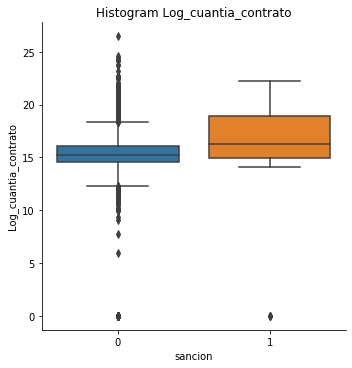

<Figure size 432x288 with 0 Axes>

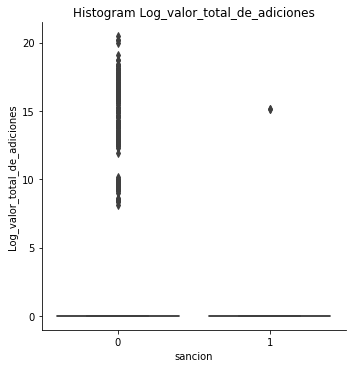

<Figure size 432x288 with 0 Axes>

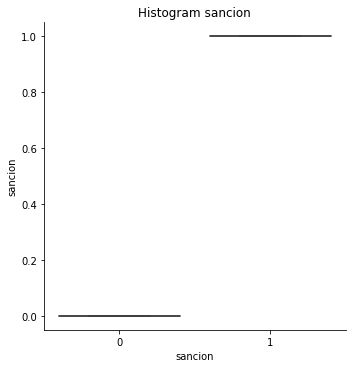

<Figure size 432x288 with 0 Axes>

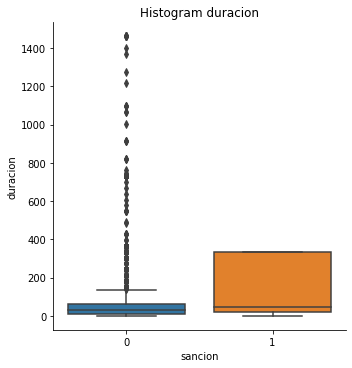

<Figure size 432x288 with 0 Axes>

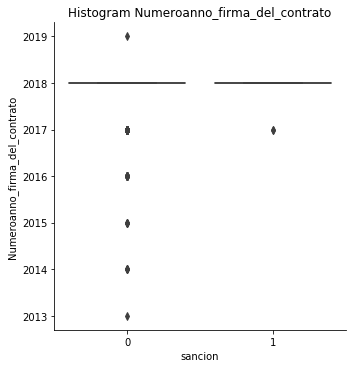

<Figure size 432x288 with 0 Axes>

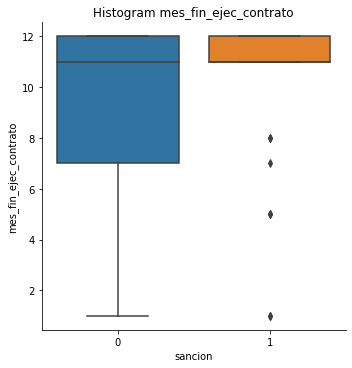

<Figure size 432x288 with 0 Axes>

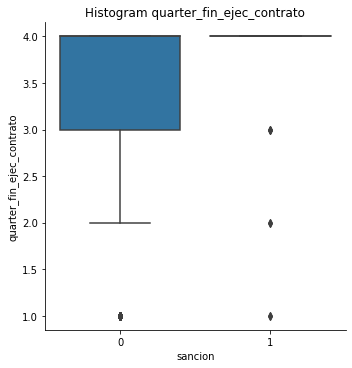

<Figure size 432x288 with 0 Axes>

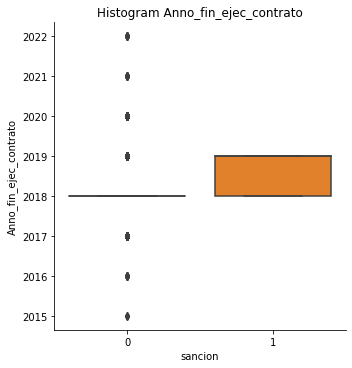

<Figure size 432x288 with 0 Axes>

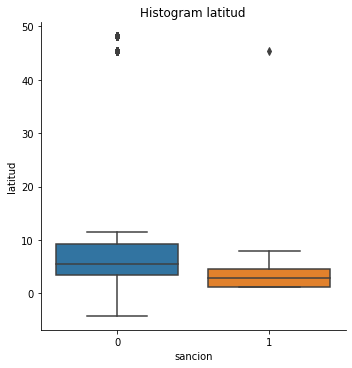

<Figure size 432x288 with 0 Axes>

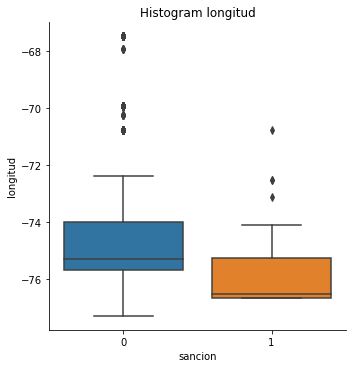

<Figure size 432x288 with 0 Axes>

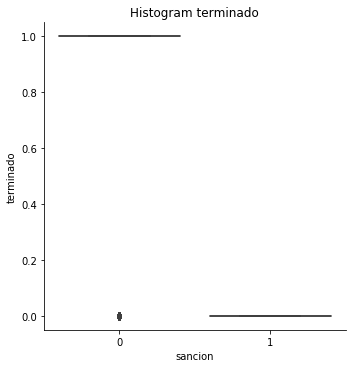

<Figure size 432x288 with 0 Axes>

In [70]:
import matplotlib.pyplot as plt

for i in df[ColCluster2].select_dtypes(exclude=['object']).columns.unique():
    sns.factorplot (x="sancion", y=i, kind="box", data=df[ColCluster2]);
    plt.title('Histogram {}'.format(i))
    plt.figure()

#### Kmeans





In [0]:
def deal_with_nans(x, thresh=0.7):
    """
    Deal with nan data
    First drop columns for which there isn't enoug data.
    Then fill missing values using median for continuous features and mode for categorical
    Finally drop columns with no variability
    :param x: (pandas.DataFrame) features dataframe
    :param thresh: (float) features with missing values below the thresh are discarted
    :return: (pandas.DataFrame) cleaned dataframe
    """

    # Drop rows with no data
    dff = x.dropna(how='all')

    # Drops columns with not enough data
    dff.dropna(thresh=thresh * len(dff), axis=1, inplace=True)

    # Identify continuous features
    float_vars = [y for y in dff.columns if 'float' in str(dff[y].dtype)]

    # Fill missing values
    for feat in dff.columns:
        if feat in float_vars:
            # Fill continuous features with median
            dff[feat] = dff[feat].fillna(dff[feat].median())
        else:
            # Fill categorical features with mode
            dff[feat] = dff[feat].fillna(dff[feat].mode()[0])

    # Drops columns with no variability
    dff = dff[[y for y in dff.columns if len(dff[y].unique()) > 1]]

    # Returns dataframe with no NaNs
    return dff


def clean_outliers(x, alpha=0.05):
    """
    Put all outliers on the confidence interval limit.
    :param x: (pandas.DataFrame) matrix of features
    :param alpha: (float) significance, 5% by default
    :return: (pandas.DataFrame) matrix with no outliers
    """

    # Cleaning Initialization
    x_c = x.copy()

    # Identification of categorical variables
    cont_vars = [x for x in x_c.columns if 'float' in str(x_c[x].dtype)]

    # If no continuous variables
    if len(cont_vars) == 0:
        return x_c

    # Cleaning
    for var in cont_vars:
        ll = x_c[var].quantile(alpha)
        ul = x_c[var].quantile(1-alpha)
        x_c[var] = [ll if x < ll else (ul if x > ul else x) for x in x_c[var]]

    # Return
    return x_c


def standarize(x):
    """
    Normalize data
    :param x: (pandas.DataFrame) matrix to normalize
    :return: (pandas.DataFrame) normalized matrix
    """

    # Outliers Treatment
    x_oc = clean_outliers(x)

    scale = StandardScaler()
    return pd.DataFrame(scale.fit_transform(x_oc), columns=x.columns, index=x_oc.index)


def get_principal_componets(x, n_pca=None):
    """
    Obtain the principal components from a set of continuous features.
    If the number of components is not especified, the model find the minimum number
    required to explain 90% of variance.
    :param x: (pandas.DataFrame) matrix from which the components are extracted
    :param n_pca: number of components
    :return: (pandas.DataFrame) matrix of components
    """

    # Standarization
    x_std = standarize(x)

    # Identify minimum number of components to explain 90% of the variability
    if n_pca is None:
        pca = PCA(random_state=1234)
        pca.fit(x_std)
        loadings = [round(y, 2) for y in pca.explained_variance_ratio_]
        cumsumload = list(np.cumsum(loadings))
        ncomps = [(y + 1, cumsumload[y]) for y in range(len(cumsumload))]
        n_pca = [y for y in ncomps if y[1] >= 0.8][0][0]

    # Calculate and return pcs
    pca = PCA(n_components=n_pca, random_state=1234)
    dp = pd.DataFrame(
        pca.fit_transform(x_std),
        columns=['PCA '+str(i+1) for i in range(n_pca)],
        index=x.index
    )
    return dp


Selección de columnas de interés y prerpocesamiento para standarizar las variables númericas y hacer One-hot-encoding a las variables categoricas

In [0]:
dfCluster=df[ColCluster2].replace([np.inf, -np.inf], np.nan)

In [0]:
#Separación del tipo de datos
df_Numeric = dfCluster.select_dtypes(include=['float64','int64'])
df_Cat = dfCluster.select_dtypes(include=['object'])

In [0]:

df_Numeric=df_Numeric.replace([np.inf, -np.inf], np.nan)
df_Numeric=deal_with_nans(df_Numeric) 

In [0]:
# Estandarización de datos
scaler = StandardScaler()
# fit df
scaler.fit(df_Numeric)
StandardScaler(copy=True, with_mean=True, with_std=True)

df_StandScale = scaler.transform(df_Numeric)
# Df transform
df_StandScale= pd.DataFrame(df_StandScale, columns=df_Numeric.columns)

In [0]:
## integer categorical
from sklearn import preprocessing
le = preprocessing.LabelEncoder()

In [79]:
# apply le on categorical feature columns
df_Cat = df_Cat.apply(lambda col: le.fit_transform(col))
df_Cat.head(10)

,nivel_entidad,orden_entidad,municipio_obtencion,municipio_entrega,quarter_fin_contrato_departamento_ejecucion,municipios_ejecucion
0,1,6,298,274,110,293
1,1,6,172,274,102,237
2,1,10,302,278,35,419
3,1,3,324,214,94,319
4,1,4,298,274,73,486
5,1,7,298,274,24,689
6,1,10,298,274,64,640
7,1,6,40,36,90,47
8,0,2,298,274,16,74
9,0,2,298,274,102,78


In [80]:
df_Cat.head()

,nivel_entidad,orden_entidad,municipio_obtencion,municipio_entrega,quarter_fin_contrato_departamento_ejecucion,municipios_ejecucion
0,1,6,298,274,110,293
1,1,6,172,274,102,237
2,1,10,302,278,35,419
3,1,3,324,214,94,319
4,1,4,298,274,73,486


In [0]:
#df_Cat_OHE= pd.get_dummies(df_Cat)
#df_Cat_OHE.shape

In [0]:
# PCA con el objetivo de reducir dimensionalmente la cantidad de columnas 

In [0]:
def Pca_Explication(X):
    """
    Get the explain variance by each PC element.
    Params: X dataframe to transform
    Return: 
    """
    pca= PCA(n_components = None)
    df_PCA = pca.fit_transform(X)
    Exp_var = pca.explained_variance_ratio_
    Exp_var=pd.DataFrame(Exp_var, columns=['VarExpPor'])
    Exp_var["cum"]=Exp_var.VarExpPor.cumsum()
    return Exp_var

In [0]:
#Pca_Explication(df_Cat_OHE).T

In [0]:
#df_Cat_OHEPCA=get_principal_componets(df_Cat_OHE,80)

Obtención de pca de df numerico y df categorico

In [0]:
df_SOHE = pd.merge(df_Numeric, df_Cat, left_index=True, right_index=True, suffixes=('_Num', '_Cat'))

In [86]:
df_SOHE.head()

,Log_cuantia_contrato,Log_valor_total_de_adiciones,sancion,duracion,Numeroanno_firma_del_contrato,mes_fin_ejec_contrato,quarter_fin_ejec_contrato,Anno_fin_ejec_contrato,latitud,longitud,terminado,nivel_entidad,orden_entidad,municipio_obtencion,municipio_entrega,quarter_fin_contrato_departamento_ejecucion,municipios_ejecucion
0,14.648420,0.0,0,30.0,2018,12,4,2018,4.438890,-75.232224,1,1,6,298,274,110,293
1,14.346139,0.0,0,30.0,2018,12,4,2018,7.125390,-73.119797,1,1,6,172,274,102,237
2,14.508658,0.0,0,30.0,2018,12,4,2018,5.337750,-72.395859,1,1,10,302,278,35,419
3,14.850828,0.0,0,15.0,2018,12,4,2018,48.133302,-75.696114,1,1,3,324,214,94,319
4,14.747675,0.0,0,31.0,2018,1,1,2019,4.142000,-73.626640,1,1,4,298,274,73,486


In [0]:
# Descripción distribución de datos en función de la categoría sancionado

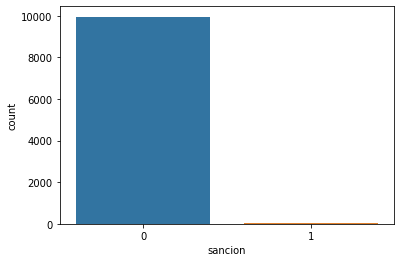

In [88]:
ax = sns.countplot(x="sancion", data=df_SOHE)

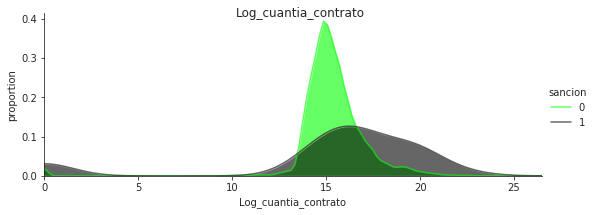

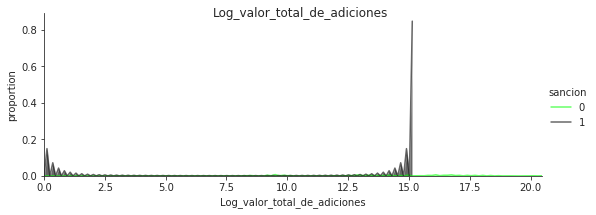

/usr/local/lib/python3.6/dist-packages/statsmodels/nonparametric/kde.py:487: RuntimeWarning:

invalid value encountered in true_divide

/usr/local/lib/python3.6/dist-packages/statsmodels/nonparametric/kdetools.py:34: RuntimeWarning:

invalid value encountered in double_scalars



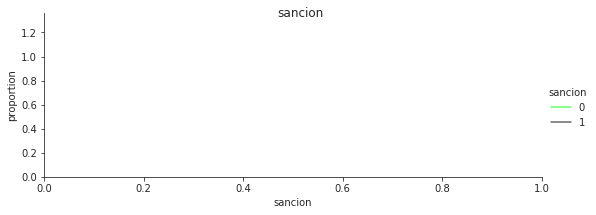

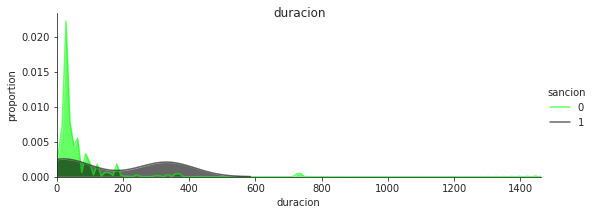

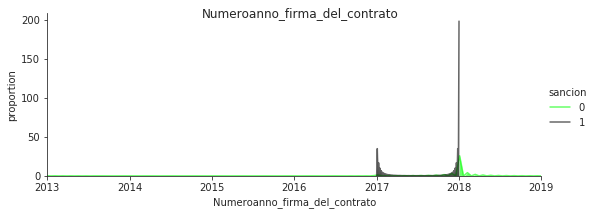

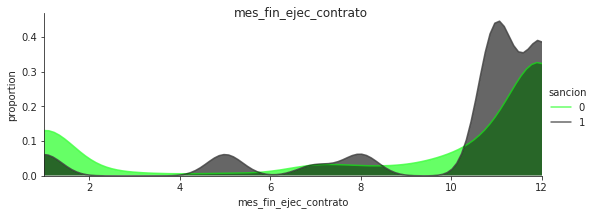

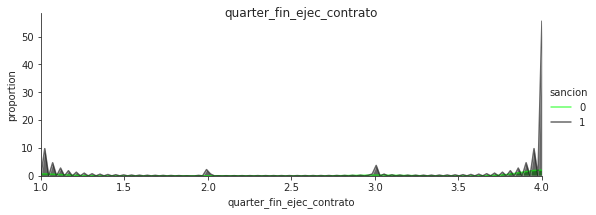

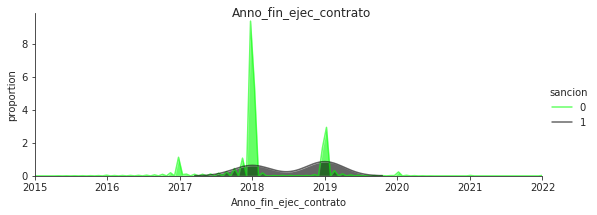

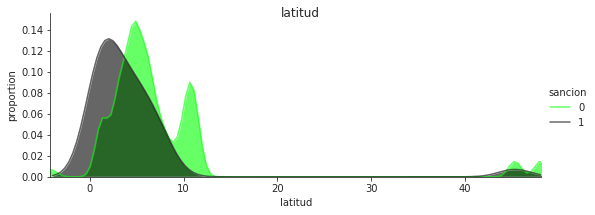

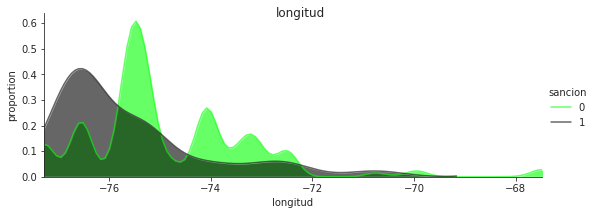

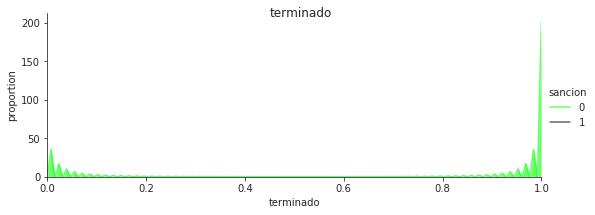

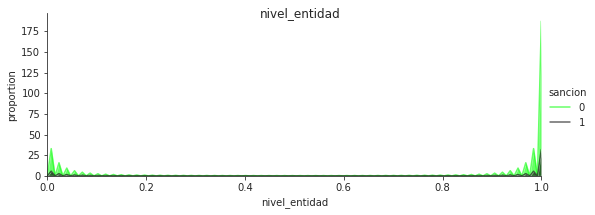

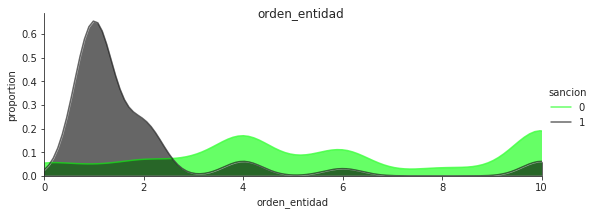

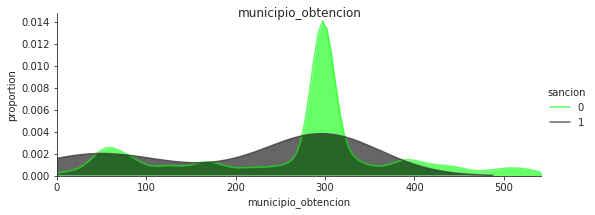

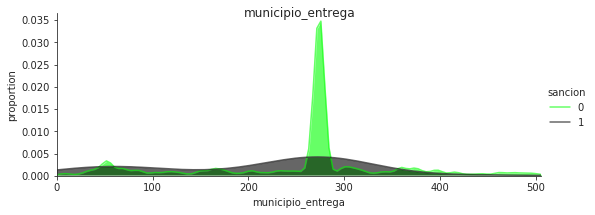

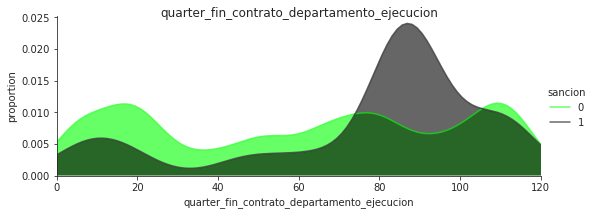

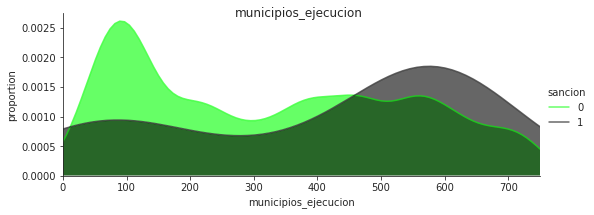

In [92]:
def plot_distribution(data_select): 
    figsize =( 15, 8)
    sns.set_style("ticks")
    s = sns.FacetGrid(df_SOHE, hue = 'sancion',aspect = 2.5, palette ={0 : 'lime', 1 :'black'})
    s.map(sns.kdeplot, data_select, shade = True, alpha = 0.6)
    s.set(xlim=(df_SOHE[data_select].min(), df_SOHE[data_select].max()))
    s.add_legend()
    s.set_axis_labels(data_select, 'proportion')
    s.fig.suptitle(data_select)
    plt.show()

for i in df_SOHE.columns.unique():
   plot_distribution(i)   

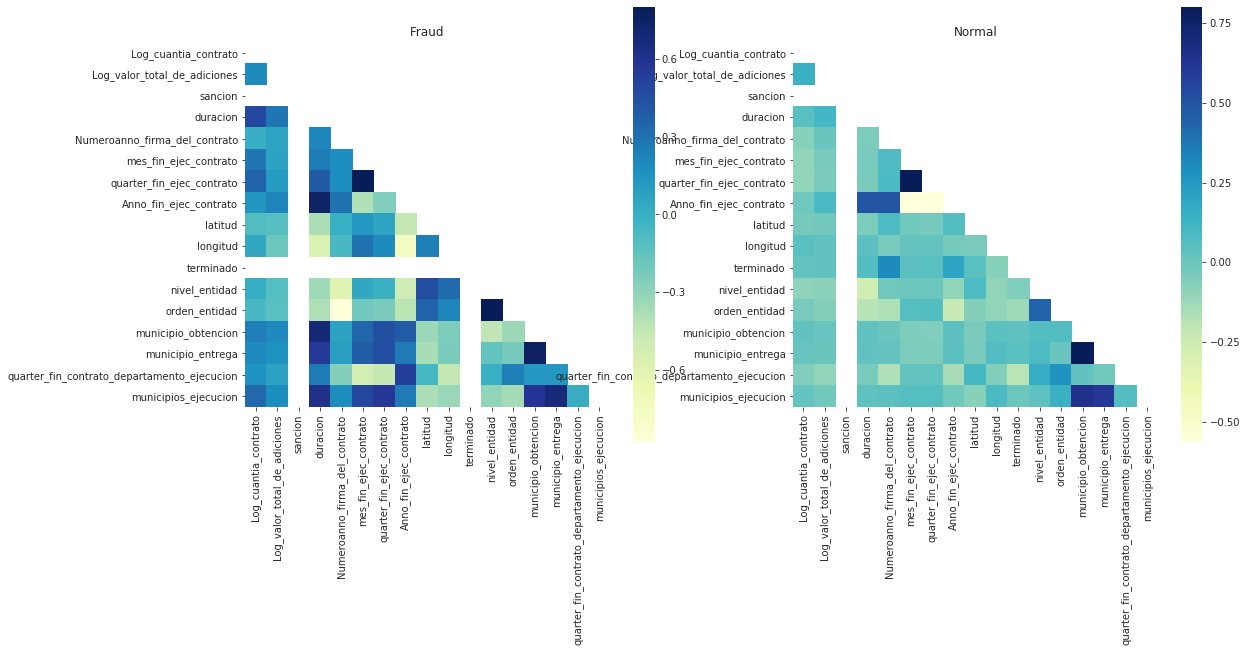

In [95]:
f, (ax1, ax2) = plt.subplots(1,2,figsize =( 18, 8))
corr = df_SOHE.corr()
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True
sns.heatmap((df_SOHE.loc[df_SOHE['sancion'] ==1]).corr(), vmax = .8, square=True, ax = ax1, cmap = 'YlGnBu', mask=mask);
ax1.set_title('Fraud')
sns.heatmap((df_SOHE.loc[df_SOHE['sancion'] ==0]).corr(), vmax = .8, square=True, ax = ax2, cmap = 'YlGnBu', mask=mask);
ax2.set_title('Normal')
plt.show()

In [0]:
#### Kmeans sobre unión de df categoricos
X=df_SOHE.copy()
X=X.drop(columns=["sancion","terminado"])

In [0]:
y=df_SOHE["sancion"]

In [99]:
## Generación de modelo #1 - Modelo sin estratificación del modelo 

from sklearn.metrics import precision_score, roc_auc_score, recall_score, confusion_matrix, roc_curve, precision_recall_curve, accuracy_score
import plotly.offline as py
py.init_notebook_mode(connected=True)
import plotly.graph_objs as go
import plotly.tools as tls
from plotly.tools import FigureFactory as FF
import warnings
warnings.filterwarnings('ignore')

In [0]:
def model_performance(model,y_test, y_pred,y_score): 
    #Conf matrix
    conf_matrix = confusion_matrix(y_test, y_pred)
    trace1 = go.Heatmap(z = conf_matrix  ,x = ["0 (pred)","1 (pred)"],
                        y = ["0 (true)","1 (true)"],xgap = 2, ygap = 2, 
                        colorscale = 'Viridis', showscale  = False)

    #Show metrics
    tp = conf_matrix[1,1]
    fn = conf_matrix[1,0]
    fp = conf_matrix[0,1]
    tn = conf_matrix[0,0]
    Accuracy  =  ((tp+tn)/(tp+tn+fp+fn))
    Precision =  (tp/(tp+fp))
    Recall    =  (tp/(tp+fn))
    F1_score  =  (2*(((tp/(tp+fp))*(tp/(tp+fn)))/((tp/(tp+fp))+(tp/(tp+fn)))))
    data=[[Accuracy , Precision, Recall, F1_score]]
    show_metrics = pd.DataFrame(data=[[Accuracy , Precision, Recall, F1_score]])
    show_metrics = show_metrics.T

    colors = ['gold', 'lightgreen', 'lightcoral', 'lightskyblue']
    trace2 = go.Bar(x = (show_metrics[0].values), 
                   y = ['Accuracy', 'Precision', 'Recall', 'F1_score'], text = np.round_(show_metrics[0].values,4),
                    textposition = 'auto',
                   orientation = 'h', opacity = 0.8,marker=dict(
            color=colors,
            line=dict(color='#000000',width=1.5)))
    
    #Roc curve
    model_roc_auc = round(roc_auc_score(y_test, y_score) , 3)
    fpr, tpr, t = roc_curve(y_test, y_score)
    trace3 = go.Scatter(x = fpr,y = tpr,
                        name = "Roc : " + str(model_roc_auc),
                        line = dict(color = ('rgb(22, 96, 167)'),width = 2), fill='tozeroy')
    trace4 = go.Scatter(x = [0,1],y = [0,1],
                        line = dict(color = ('black'),width = 1.5,
                        dash = 'dot'))
    
    # Precision-recall curve
    precision, recall, thresholds = precision_recall_curve(y_test, y_score)
    trace5 = go.Scatter(x = recall, y = precision,
                        name = "Precision" + str(precision),
                        line = dict(color = ('lightcoral'),width = 2), fill='tozeroy')
    
    '''#Feature importance
    coefficients  = pd.DataFrame(model.feature_importances_)
    column_data   = pd.DataFrame(list(data))
    coef_sumry    = (pd.merge(coefficients,column_data,left_index= True,
                              right_index= True, how = "left"))
    coef_sumry.columns = ["coefficients","features"]
    coef_sumry    = coef_sumry.sort_values(by = "coefficients",ascending = False)
    coef_sumry = coef_sumry[coef_sumry["coefficients"] !=0]
    trace6 = go.Bar(x = coef_sumry["features"],y = coef_sumry["coefficients"],
                    name = "coefficients",
                    marker = dict(color = coef_sumry["coefficients"],
                                  colorscale = "Viridis",
                                  line = dict(width = .6,color = "black")))'''
    
    #Cumulative gain
    pos = pd.get_dummies(y_test).as_matrix()
    pos = pos[:,1] 
    npos = np.sum(pos)
    index = np.argsort(y_score) 
    index = index[::-1] 
    sort_pos = pos[index]
    #cumulative sum
    cpos = np.cumsum(sort_pos) 
    #recall
    recall = cpos/npos 
    #size obs test
    n = y_test.shape[0] 
    size = np.arange(start=1,stop=369,step=1) 
    #proportion
    size = size / n 
    #plots
    model = model
    trace7 = go.Scatter(x = size,y = recall,
                        name = "Lift curve",
                        line = dict(color = ('gold'),width = 2), fill='tozeroy') 
    
    #Subplots
    fig = tls.make_subplots(rows=4, cols=2, print_grid=False, 
                          specs=[[{}, {}], 
                                 [{}, {}],
                                 [{'colspan': 2}, None],
                                 [{'colspan': 2}, None]],
                          subplot_titles=('Confusion Matrix',
                                        'Metrics',
                                        'ROC curve'+" "+ '('+ str(model_roc_auc)+')',
                                        'Precision - Recall curve',
                                        'Cumulative gains curve',
                                        #'Feature importance',
                                        ))
    
    fig.append_trace(trace1,1,1)
    fig.append_trace(trace2,1,2)
    fig.append_trace(trace3,2,1)
    fig.append_trace(trace4,2,1)
    fig.append_trace(trace5,2,2)
    #fig.append_trace(trace6,4,1)
    fig.append_trace(trace7,3,1)
    
    fig['layout'].update(showlegend = False, title = '<b>Model performance report</b><br>'+str(model),
                        autosize = False, height = 1500,width = 830,
                        plot_bgcolor = 'rgba(240,240,240, 0.95)',
                        paper_bgcolor = 'rgba(240,240,240, 0.95)',
                        margin = dict(b = 195))
    fig["layout"]["xaxis2"].update((dict(range=[0, 1])))
    fig["layout"]["xaxis3"].update(dict(title = "false positive rate"))
    fig["layout"]["yaxis3"].update(dict(title = "true positive rate"))
    fig["layout"]["xaxis4"].update(dict(title = "recall"), range = [0,1.05])
    fig["layout"]["yaxis4"].update(dict(title = "precision"), range = [0,1.05])
    fig["layout"]["xaxis5"].update(dict(title = "Percentage contacted"))
    fig["layout"]["yaxis5"].update(dict(title = "Percentage positive targeted"))
    fig.layout.titlefont.size = 14
    
    return py.iplot(fig)
    #return fig.show()

In [0]:
#accuracy=cross_val_score(clf, X_train, y_train, scoring=balanced_accuracy_score, cv=3).mean()

In [102]:
from warnings import filterwarnings

#train test split
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.metrics import balanced_accuracy_score, make_scorer
from sklearn.metrics import accuracy_score, roc_auc_score
from hyperopt import hp, fmin, tpe, STATUS_OK, Trials
import numpy as np
import xgboost as xgb

   
# train test split
X_train, X_test, y_train, y_test = train_test_split(X, y,test_size=0.3, random_state=1234)

def objective(space):
    # Instantiate the classifier
    clf = xgb.XGBClassifier(#tree_method='gpu_hist', gpu_id=0,
                            n_estimators =int(space["n_estimators"]),
                            colsample_bytree=space['colsample_bytree'],
                           learning_rate = .3,
                            max_depth = int(space['max_depth']),
                            min_child_weight = space['min_child_weight'],
                            subsample = space['subsample'],
                           gamma = space['gamma'],
                           reg_lambda = space['reg_lambda'])
    
    
    
    # Fit the classsifier
    
    
    clf.fit(X_train, y_train,eval_metric=balanced_accuracy_score)
    
    
    # Calculate our Metric - accuracy
    
    
    accuracy=cross_val_score(clf, X_train, y_train, scoring=make_scorer(balanced_accuracy_score), cv=3).mean()
# return needs to be in this below format. We use negative of accuracy since we want to maximize it.
    return {'loss': -accuracy, 'status': STATUS_OK }

space ={'n_estimators':hp.quniform ('x_n_estimators', 100, 1000, 100),
        'max_depth': hp.quniform("x_max_depth", 4, 16, 1),
        'min_child_weight': hp.quniform ('x_min_child_weight', 1, 10, 1),
        'subsample': hp.uniform ('x_subsample', 0.7, 1),
        'gamma' : hp.uniform ('x_gamma', 0.1,0.5),
        'colsample_bytree' : hp.uniform ('x_colsample_bytree', 0.7,1),
        'reg_lambda' : hp.uniform ('x_reg_lambda', 0,1)
    }


trials = Trials()
best = fmin(fn=objective,
            space=space,
            algo=tpe.suggest,
            max_evals=5,
            trials=trials,
            rstate=np.random.RandomState(1234)
            )
print(best)



#XGBoost randomsearchCV
best_fit = xgb.XGBClassifier(#tree_method='gpu_hist', gpu_id=0,
                            n_estimators =int(best["x_n_estimators"]),
                            colsample_bytree=best['x_colsample_bytree'],
                           learning_rate = .3,
                            max_depth = int(best['x_max_depth']),
                            min_child_weight = best['x_min_child_weight'],
                            subsample = best['x_subsample'],
                           gamma = best['x_gamma'],
                           reg_lambda = best['x_reg_lambda'])
# fit XGB
best_fit.fit(X_train, y_train,eval_metric=balanced_accuracy_score)
    
print("y predict xg")
y_pred = best_fit.predict(X_train)
y_score = best_fit.predict_proba(X_test)[:,1]

y_pred_test = best_fit.predict(X_test)

XG_train_score = balanced_accuracy_score(y_train,y_pred)
XG_test_score = balanced_accuracy_score(y_test, y_pred_test)


print("El Score de training del modelo XG fue: {}".format(XG_train_score))
print("El Score de test del modelo  XG fue: {}".format(XG_test_score))


# Explained Variability Calculation
importances = pd.DataFrame(best_fit.feature_importances_.tolist(), columns=['explanation'])
features = pd.DataFrame(X_train.columns.tolist(), columns=['feature'])
df = pd.concat([features, importances], axis=1)
#df.explanation = df.explanation * best_fit.score(X_train, y_train) * 100
df.sort_values('explanation', ascending=False, inplace=True)
df.set_index('feature', inplace=True)    
 


100%|██████████| 5/5 [00:10<00:00,  1.96s/it, best loss: -0.5]
{'x_colsample_bytree': 0.8702223906761407, 'x_gamma': 0.19660346387492067, 'x_max_depth': 8.0, 'x_min_child_weight': 9.0, 'x_n_estimators': 100.0, 'x_reg_lambda': 0.1130526021429622, 'x_subsample': 0.9271541922003506}
y predict xg
El Score de training del modelo XG fue: 0.7114667255269838
El Score de test del modelo  XG fue: 0.7142857142857143


In [103]:
df.head(10)

,explanation
feature,
nivel_entidad,0.192488
latitud,0.153304
quarter_fin_contrato_departamento_ejecucion,0.151357
longitud,0.111343
orden_entidad,0.078853
municipios_ejecucion,0.077129
mes_fin_ejec_contrato,0.066043
municipio_entrega,0.059857
Log_cuantia_contrato,0.039688


In [0]:
conf_matrix = confusion_matrix(y_test, y_pred_test)
trace1 = go.Heatmap(z = conf_matrix  ,x = ["0 (pred)","1 (pred)"],
                      y = ["0 (true)","1 (true)"],xgap = 2, ygap = 2, 
                        colorscale = 'Viridis', showscale  = False)

#Show metrics
tp = conf_matrix[1,1]
fn = conf_matrix[1,0]
fp = conf_matrix[0,1]
tn = conf_matrix[0,0]
Accuracy  =  ((tp+tn)/(tp+tn+fp+fn))
Precision =  (tp/(tp+fp))
Recall    =  (tp/(tp+fn))
F1_score  =  (2*(((tp/(tp+fp))*(tp/(tp+fn)))/((tp/(tp+fp))+(tp/(tp+fn)))))
data=[[Accuracy , Precision, Recall, F1_score]]

#Roc curve
model_roc_auc = round(roc_auc_score(y_test, y_score) , 3)
fpr, tpr, t = roc_curve(y_test, y_score)
trace3 = go.Scatter(x = fpr,y = tpr,
                     name = "Roc : " + str(model_roc_auc),
                        line = dict(color = ('rgb(22, 96, 167)'),width = 2), fill='tozeroy')
trace4 = go.Scatter(x = [0,1],y = [0,1],
                        line = dict(color = ('black'),width = 1.5,
                        dash = 'dot'))

In [105]:
conf_matrix

array([[2992,    0],
       [   4,    3]])

In [106]:
model_roc_auc

0.984

In [107]:
from sklearn.metrics import balanced_accuracy_score
balanced_accuracy_score(y_test, y_pred_test)

0.7142857142857143

In [108]:
model_performance(best_fit,y_test, y_pred_test,y_score)

In [0]:
# ANN

In [109]:
import keras

Using TensorFlow backend.


In [110]:
from keras.models import Sequential
from keras.layers import Dense, Dropout
model = Sequential([
    Dense(units=20, input_dim = X_train.shape[1], activation='relu'),
    Dense(units=24,activation='relu'),
    Dropout(0.5),
    Dense(units=20,activation='relu'),
    Dense(units=24,activation='relu'),
    Dense(1, activation='sigmoid')
])
model.summary()






Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 20)                320       
_________________________________________________________________
dense_2 (Dense)              (None, 24)                504       
_________________________________________________________________
dropout_1 (Dropout)          (None, 24)                0         
_________________________________________________________________
dense_3 (Dense)              (None, 20)                500       
_________________________________________________________________
dense_4 (Dense)              (None, 24)                504       
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 25        
T

In [111]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model.fit(X_train, y_train, batch_size=30, epochs=15)





Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where



Epoch 1/15





6996/6996 [==============================] - 1s 153us/step - loss: 3.8585 - acc: 0.7551
Epoch 2/15
6996/6996 [==============================] - 0s 48us/step - loss: 0.0615 - acc: 0.9961
Epoch 3/15
6996/6996 [==============================] - 0s 47us/step - loss: 0.0612 - acc: 0.9961
Epoch 4/15
6996/6996 [==============================] - 0s 46us/step - loss: 0.0600 - acc: 0.9961
Epoch 5/15
6996/6996 [==============================] - 0s 46us/step - loss: 0.0600 - acc: 0.9963
Epoch 6/15
6996/6996 [==============================] - 0s 46us/step - loss: 0.0600 - acc: 0.9961
Epoch 7/15
6996/6996 [==============================] - 0s 46us/step - loss: 0.0599 - acc: 0.9963
Epoch 8/15
6996/6996 [==============================] - 0s 48us/step - loss: 0.0599 - acc: 0.9963
Epoch 9/15
6996/6996 [==============================] - 0s 47us/step - loss: 0.0599 - acc: 0.9963
Epoch 10/15
6

In [112]:
score = model.evaluate(X_test, y_test)
print('Test Accuracy: {:.2f}%\nTest Loss: {}'.format(score[1]*100,score[0]))

2999/2999 [==============================] - 0s 40us/step
Test Accuracy: 99.77%
Test Loss: 0.03762152672128955


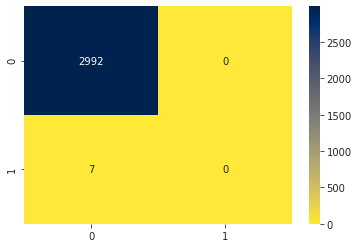

In [113]:
y_predN = model.predict(X_test)
y_test = pd.DataFrame(y_test)
cm = confusion_matrix(y_test, y_predN.round())
sns.heatmap(cm, annot=True, fmt='.0f', cmap='cividis_r')
plt.show()

In [0]:
#SMOTE Sampling

In [143]:
from imblearn.over_sampling import SMOTE
X_smote, y_smote = SMOTE().fit_sample(X, y)
X_smote = pd.DataFrame(X_smote)
y_smote = pd.DataFrame(y_smote)
y_smote.iloc[:,0].value_counts()

1    9962
0    9962
Name: 0, dtype: int64

In [0]:
X_smote.columns=X.columns

In [0]:
X_trainSmote, X_testSmote, y_trainSmote, y_testSmote = train_test_split(X_smote, y_smote, test_size=0.3, random_state=0)



In [154]:
from warnings import filterwarnings

#train test split
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.metrics import balanced_accuracy_score, make_scorer
from sklearn.metrics import accuracy_score, roc_auc_score
from hyperopt import hp, fmin, tpe, STATUS_OK, Trials
import numpy as np
import xgboost as xgb

def objective(space):
    # Instantiate the classifier
    clf = xgb.XGBClassifier(#tree_method='gpu_hist', gpu_id=0,
                            n_estimators =int(space["n_estimators"]),
                            colsample_bytree=space['colsample_bytree'],
                           learning_rate = .3,
                            max_depth = int(space['max_depth']),
                            min_child_weight = space['min_child_weight'],
                            subsample = space['subsample'],
                           gamma = space['gamma'],
                           reg_lambda = space['reg_lambda'])
    
    
    
    # Fit the classsifier
    
    
    clf.fit(X_trainSmote, y_trainSmote,eval_metric=balanced_accuracy_score)
    
    
    # Calculate our Metric - accuracy
    
    
    accuracy=cross_val_score(clf, X_trainSmote, y_trainSmote, scoring=make_scorer(balanced_accuracy_score), cv=3).mean()
# return needs to be in this below format. We use negative of accuracy since we want to maximize it.
    return {'loss': -accuracy, 'status': STATUS_OK }

space ={'n_estimators':hp.quniform ('x_n_estimators', 100, 1000, 100),
        'max_depth': hp.quniform("x_max_depth", 4, 16, 1),
        'min_child_weight': hp.quniform ('x_min_child_weight', 1, 10, 1),
        'subsample': hp.uniform ('x_subsample', 0.7, 1),
        'gamma' : hp.uniform ('x_gamma', 0.1,0.5),
        'colsample_bytree' : hp.uniform ('x_colsample_bytree', 0.7,1),
        'reg_lambda' : hp.uniform ('x_reg_lambda', 0,1)
    }


trials = Trials()
best = fmin(fn=objective,
            space=space,
            algo=tpe.suggest,
            max_evals=5,
            trials=trials,
            rstate=np.random.RandomState(1234)
            )
print(best)



#XGBoost randomsearchCV
best_fit = xgb.XGBClassifier(#tree_method='gpu_hist', gpu_id=0,
                            n_estimators =int(best["x_n_estimators"]),
                            colsample_bytree=best['x_colsample_bytree'],
                           learning_rate = .3,
                            max_depth = int(best['x_max_depth']),
                            min_child_weight = best['x_min_child_weight'],
                            subsample = best['x_subsample'],
                           gamma = best['x_gamma'],
                           reg_lambda = best['x_reg_lambda'])
# fit XGB
best_fit.fit(X_trainSmote, y_trainSmote,eval_metric=balanced_accuracy_score)
    
print("y predict xg")
y_predSmote = best_fit.predict(X_trainSmote)
y_scoreSmote = best_fit.predict_proba(X_testSmote)[:,1]

y_pred_testSmote = best_fit.predict(X_testSmote)

XG_train_scoreSmote = balanced_accuracy_score(y_trainSmote,y_predSmote)
XG_test_scoreSmote = balanced_accuracy_score(y_testSmote, y_pred_testSmote)


print("El Score de training del modelo XG fue: {}".format(XG_train_scoreSmote))
print("El Score de test del modelo  XG fue: {}".format(XG_test_scoreSmote))


# Explained Variability Calculation
importances = pd.DataFrame(best_fit.feature_importances_.tolist(), columns=['explanation'])
features = pd.DataFrame(X_trainSmote.columns.tolist(), columns=['feature'])
df = pd.concat([features, importances], axis=1)
#df.explanation = df.explanation * best_fit.score(X_train, y_train) * 100
df.sort_values('explanation', ascending=False, inplace=True)
df.set_index('feature', inplace=True)    
 


100%|██████████| 5/5 [00:35<00:00,  6.44s/it, best loss: -0.9984943460477855]
{'x_colsample_bytree': 0.798408552130749, 'x_gamma': 0.3116225419009673, 'x_max_depth': 12.0, 'x_min_child_weight': 10.0, 'x_n_estimators': 800.0, 'x_reg_lambda': 0.2815712638436657, 'x_subsample': 0.8199466336357577}
y predict xg
El Score de training del modelo XG fue: 0.9998565485583131
El Score de test del modelo  XG fue: 0.9983269751224435


In [160]:
dfCluster.nivel_entidad.unique()

array(['TERRITORIAL', 'NACIONAL'], dtype=object)

In [162]:
pd.crosstab("sancion","nivel_entidad",dfCluster,aggfunc="count")

ValueError: ignored

In [0]:
conf_matrix = confusion_matrix(y_testSmote, y_pred_testSmote)
trace1 = go.Heatmap(z = conf_matrix  ,x = ["0 (pred)","1 (pred)"],
                      y = ["0 (true)","1 (true)"],xgap = 2, ygap = 2, 
                        colorscale = 'Viridis', showscale  = False)

#Show metrics
tp = conf_matrix[1,1]
fn = conf_matrix[1,0]
fp = conf_matrix[0,1]
tn = conf_matrix[0,0]
Accuracy  =  ((tp+tn)/(tp+tn+fp+fn))
Precision =  (tp/(tp+fp))
Recall    =  (tp/(tp+fn))
F1_score  =  (2*(((tp/(tp+fp))*(tp/(tp+fn)))/((tp/(tp+fp))+(tp/(tp+fn)))))
data=[[Accuracy , Precision, Recall, F1_score]]

#Roc curve
model_roc_auc = round(roc_auc_score(y_testSmote, y_scoreSmote) , 3)
fpr, tpr, t = roc_curve(y_testSmote, y_scoreSmote)
trace3 = go.Scatter(x = fpr,y = tpr,
                     name = "Roc : " + str(model_roc_auc),
                        line = dict(color = ('rgb(22, 96, 167)'),width = 2), fill='tozeroy')
trace4 = go.Scatter(x = [0,1],y = [0,1],
                        line = dict(color = ('black'),width = 1.5,
                        dash = 'dot'))

In [156]:
conf_matrix

array([[2981,    6],
       [   4, 2987]])

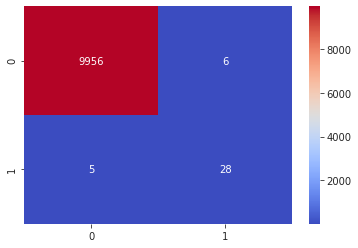

In [157]:
y_pred2 = best_fit.predict(X)
y_test2 = pd.DataFrame(y)
cm2 = confusion_matrix(y_test2, y_pred2.round())
sns.heatmap(cm2, annot=True, fmt='.0f', cmap='coolwarm')
plt.show()

In [0]:
### prueba Redes

In [0]:
X_trainSmote = np.array(X_trainSmote)
X_testSmote = np.array(X_testSmote)
y_trainSmote = np.array(y_trainSmote)
y_testSmote = np.array(y_testSmote)

In [133]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model.fit(X_trainSmote, y_trainSmote, batch_size = 30, epochs = 15)

Epoch 1/15
13946/13946 [==============================] - 1s 89us/step - loss: 7.9672 - acc: 0.4998
Epoch 2/15
13946/13946 [==============================] - 1s 49us/step - loss: 7.9608 - acc: 0.5000
Epoch 3/15
13946/13946 [==============================] - 1s 49us/step - loss: 7.9194 - acc: 0.5027
Epoch 4/15
13946/13946 [==============================] - 1s 49us/step - loss: 8.0525 - acc: 0.4997
Epoch 5/15
13946/13946 [==============================] - 1s 51us/step - loss: 8.0460 - acc: 0.5001
Epoch 6/15
13946/13946 [==============================] - 1s 50us/step - loss: 8.0472 - acc: 0.5001
Epoch 7/15
13946/13946 [==============================] - 1s 52us/step - loss: 8.0448 - acc: 0.5001
Epoch 8/15
13946/13946 [==============================] - 1s 50us/step - loss: 8.0492 - acc: 0.5001
Epoch 9/15
13946/13946 [==============================] - 1s 49us/step - loss: 8.0492 - acc: 0.5001
Epoch 10/15
13946/13946 [==============================] - 1s 49us/step - loss: 8.0503 - acc: 0.5001

In [134]:
scoreSmote = model.evaluate(X_testSmote, y_testSmote)
print('Test Accuracy: {:.2f}%\nTest Loss: {}'.format(scoreSmote[1]*100,scoreSmote[0]))

5978/5978 [==============================] - 0s 40us/step
Test Accuracy: 49.97%
Test Loss: 8.064440221521679


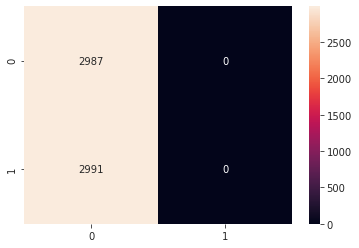

In [135]:
y_predSmote = model.predict(X_testSmote)
y_testSmote = pd.DataFrame(y_testSmote)
cmSmote = confusion_matrix(y_testSmote, y_predSmote.round())
sns.heatmap(cmSmote, annot=True, fmt='.0f')
plt.show()

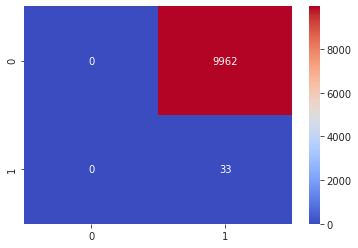

In [121]:
y_pred2 = model.predict(X)
y_test2 = pd.DataFrame(y)
cm2 = confusion_matrix(y_test2, y_pred2.round())
sns.heatmap(cm2, annot=True, fmt='.0f', cmap='coolwarm')
plt.show()

## Saving models

In [0]:
import pickle

In [0]:
# save the model to disk
filename = 'RF model 1-10k.sav'
filename2 = 'XG model 1-10k.sav'
pickle.dump(resultadoClasificadorRFXG[2], open(filename, 'wb'))
pickle.dump(resultadoClasificadorRFXG[1], open(filename2, 'wb'))